In [9]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
# import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

%matplotlib inline
plt.style.use('fivethirtyeight')
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
df_clientes = pd.read_csv("/content/mwc22-client_table.csv",decimal=',')
df_orders = pd.read_csv("/content/mwc22-orders_table.csv",decimal=',',dtype={'FRUIT_PRODUCT':'category'})
df_test = pd.read_csv("/content/mwc22-client_table+-+test_x.csv",decimal=',')
df_clientes.head()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771,6,67.25,201.75,0
1,24321859,2,58.33,350.00,0
2,24321880,3,46.67,112.00,0
3,24321957,2,50.00,600.00,0
4,24321962,4,10.00,120.00,0


In [3]:
df_orders.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


In [4]:
df_test.head()

,CLIENT ID,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,48352078,8.33,100.00,0
1,18072186,93.42,186.83,1
2,48352246,45.83,137.50,0
3,18070621,16.67,200.00,1
4,48352262,13.33,160.00,0


## Analisis exploratorio de datos (EDA)

### Dataframe orders_table

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66912 entries, 0 to 66911
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   CLIENT ID      66912 non-null  int64   
 1   NB PRODS       66912 non-null  int64   
 2   ORDER ID       66912 non-null  int64   
 3   FRUIT_PRODUCT  66912 non-null  category
dtypes: category(1), int64(3)
memory usage: 1.6 MB


In [6]:
df_orders.describe()

,CLIENT ID,NB PRODS,ORDER ID
count,6.691200e+04,66912.000000,6.691200e+04
mean,2.613407e+07,4.528112,6.722533e+08
std,8.473596e+06,5.788227,3.205826e+06
min,1.807050e+07,-80.000000,6.638335e+08
25%,2.017427e+07,1.000000,6.694803e+08
50%,2.438055e+07,3.000000,6.719971e+08
75%,2.538708e+07,5.000000,6.750893e+08
max,4.836586e+07,198.000000,6.832132e+08


NB PRODS tiene valores negativos, podria tratarse de un error de transcripcion. 

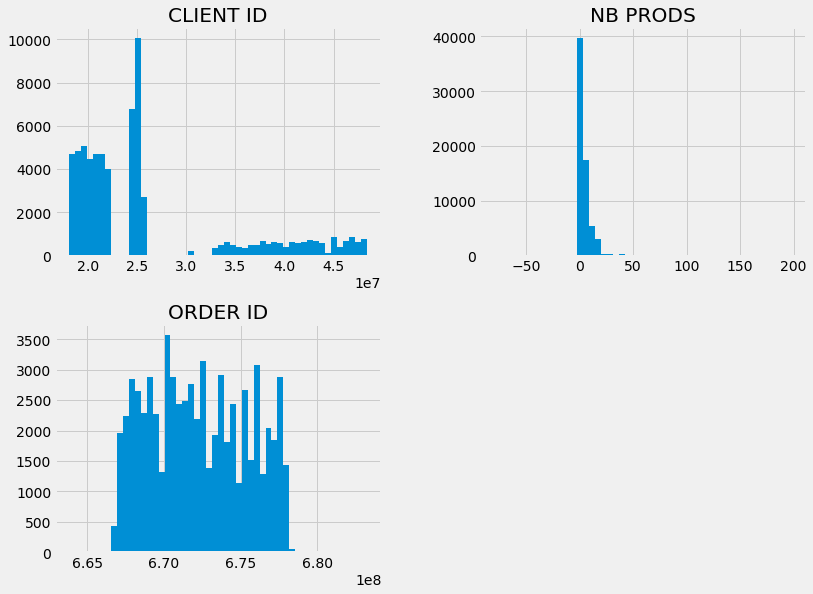

In [ ]:
_ = df_orders.hist(bins=50)

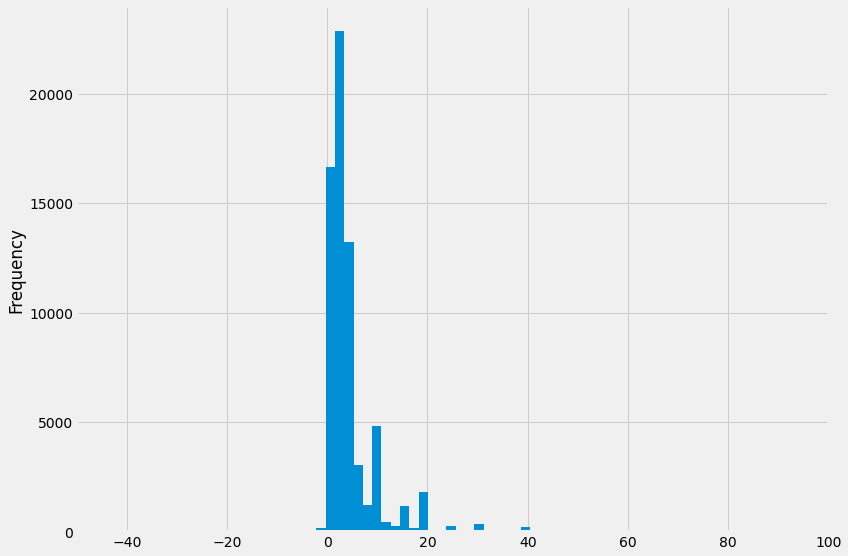

In [ ]:
_=df_orders['NB PRODS'].sort_values().plot.hist(bins=150, xlim=(-50,100))

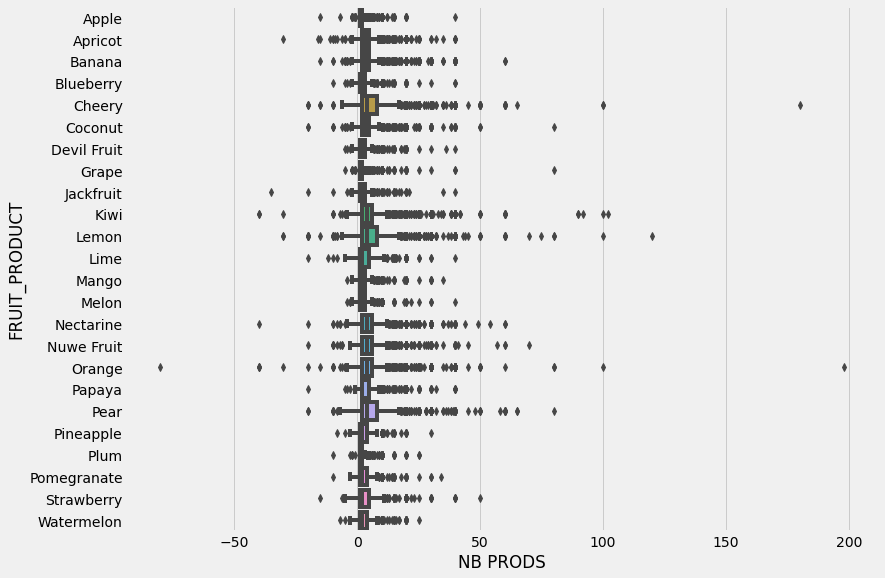

In [ ]:
_ = sns.boxplot(data=df_orders, x='NB PRODS', y='FRUIT_PRODUCT')

Se pueden observar algunos valores atipicos por encima de 150 NB PRODS, se trata de dos de los productos mas vendidos.

In [ ]:
df_orders[df_orders['NB PRODS'] > 150]

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
18396,20405483,198,675520127,Orange
41010,24477147,180,673919468,Cheery


In [ ]:
df_orders[df_orders['NB PRODS'] < 0].shape[0]

362

Hay 362 pedidos con valores negativos del numero de productos de la variedad de fruta, como no sabemos si se trata de un error de transcripcion al introducir el valor negativo optamos por eliminarlos del dataset. 
Se tendria que consultar al cliente si se trata de un error de transcripcion para cambiar el negativo por positivo y validar los datos. 

In [ ]:
df_orders_pos = df_orders[df_orders['NB PRODS'] > 0]
df_orders_pos.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


mostramos el listado de las frutas mas vendidas

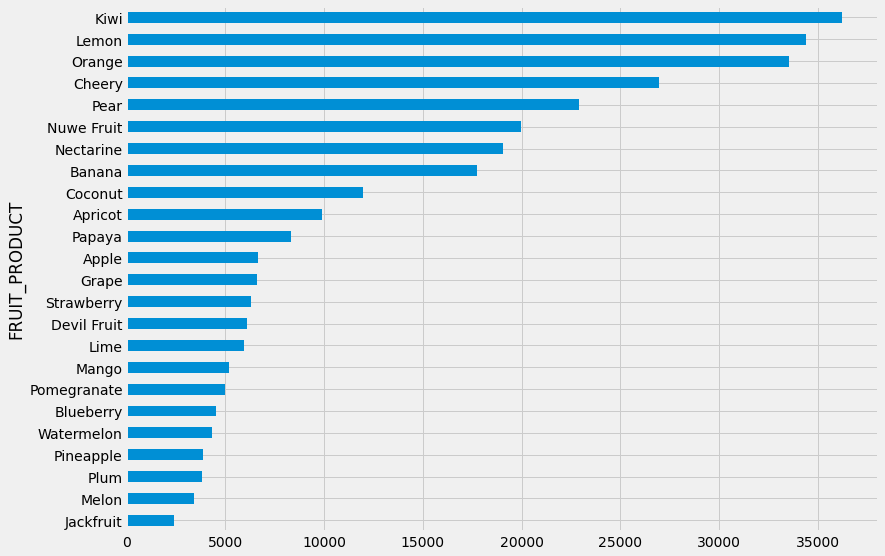

In [ ]:
_=df_orders_pos.groupby('FRUIT_PRODUCT')['NB PRODS'].sum().sort_values().plot(kind='barh')

se podria realizar mas promociones de las frutas menos vendidas.

### Dataframe orders_table

In [ ]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLIENT ID               35884 non-null  int64  
 1   CLIENT_SEGMENT          35884 non-null  int64  
 2   AVG CONSO               35884 non-null  float64
 3   AVG BASKET SIZE         35884 non-null  float64
 4   RECEIVED_COMMUNICATION  35884 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 1.4 MB


In [ ]:
df_clientes.describe()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
count,3.588400e+04,35884.000000,35884.000000,35884.000000,35884.000000
mean,2.706058e+07,3.123593,64.534437,181.218610,0.507998
std,8.835076e+06,1.512932,64.381932,129.604691,0.499943
min,1.807311e+07,1.000000,0.830000,10.000000,0.000000
25%,2.053311e+07,2.000000,20.830000,100.000000,0.000000
50%,2.462190e+07,3.000000,50.000000,160.000000,1.000000
75%,3.298538e+07,4.000000,88.170000,225.000000,1.000000
max,4.836594e+07,6.000000,2433.330000,3400.200000,1.000000


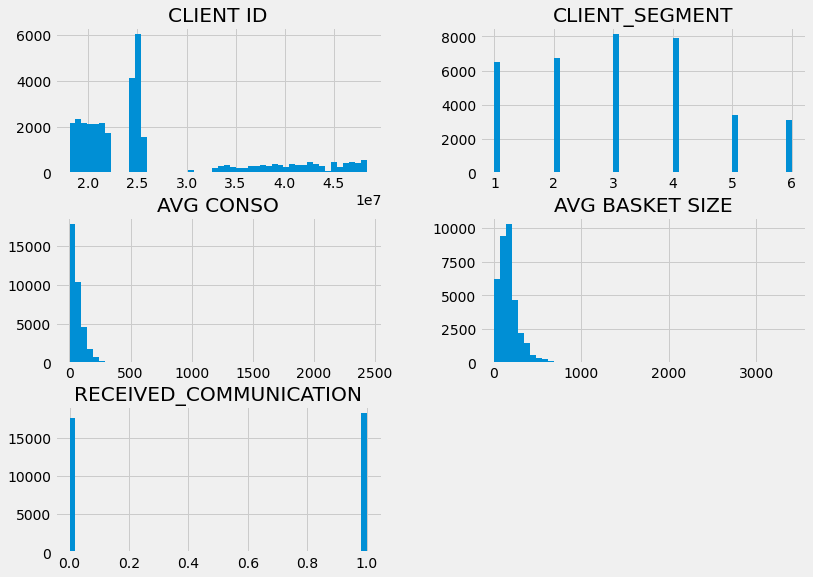

In [ ]:
_ = df_clientes.hist(bins=50)

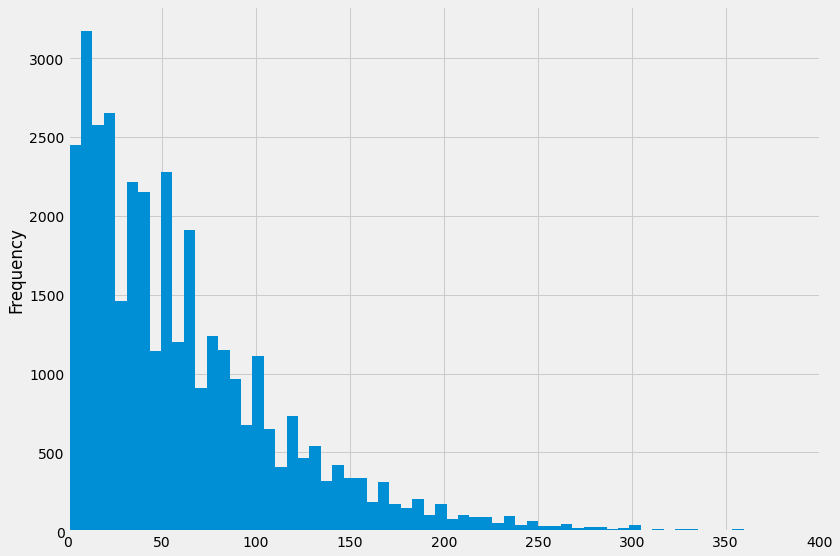

In [ ]:
_=df_clientes['AVG CONSO'].sort_values().plot.hist(bins=400, xlim=(0,400))

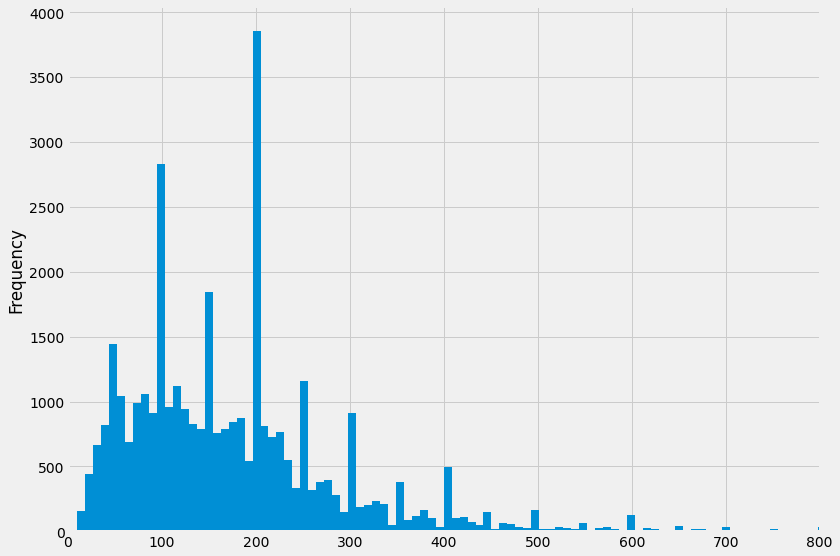

In [ ]:
_=df_clientes['AVG BASKET SIZE'].sort_values().plot.hist(bins=400, xlim=(0,800))

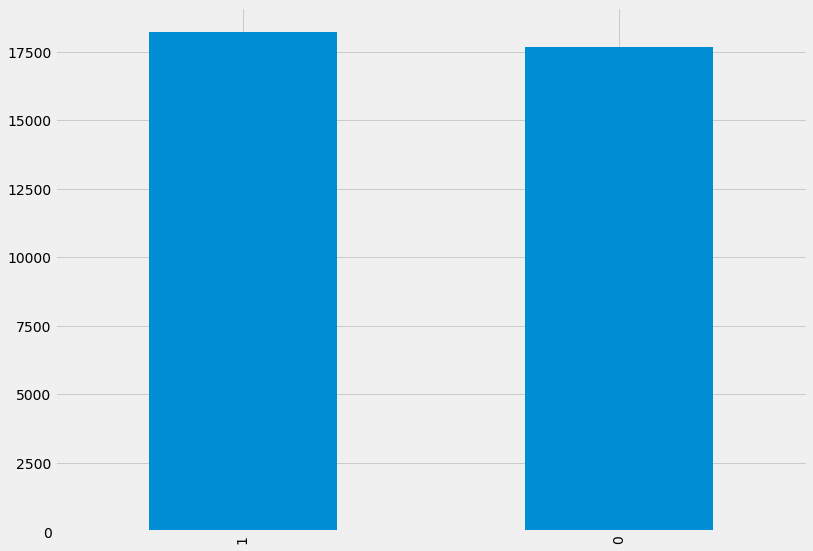

In [ ]:
df_clientes['RECEIVED_COMMUNICATION'].value_counts().plot(kind='bar')

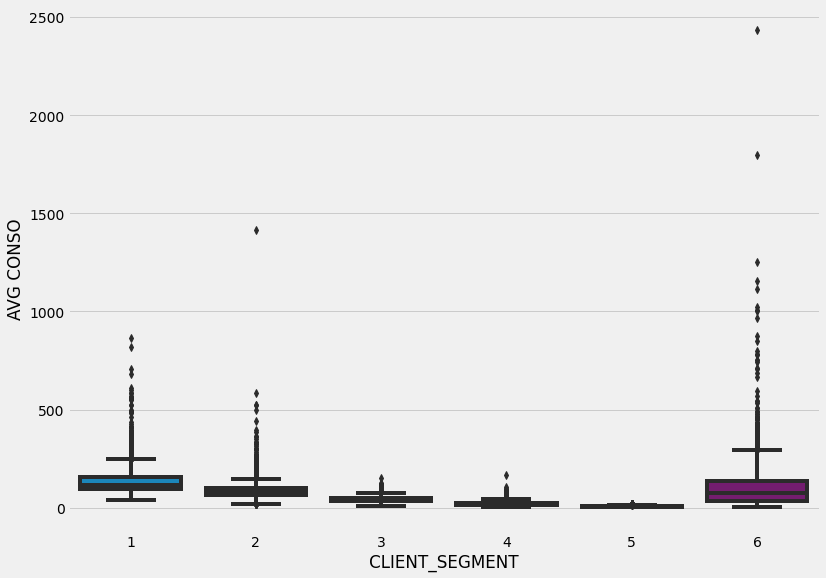

In [ ]:
_ = sns.boxplot(data=df_clientes,y='AVG CONSO', x='CLIENT_SEGMENT')

Observamos algunos valores atipicos por encima de 1400 en los clientes 2 y 6. Podemos ver que se trata de clientes que recibieron promocion.  

In [ ]:
df_clientes[df_clientes['AVG CONSO'] > 1400]

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
24465,19917710,2,1416.750,3400.200,1
28082,20939776,6,2433.330,2654.550,1
29134,21249302,6,1800.000,1350.000,1


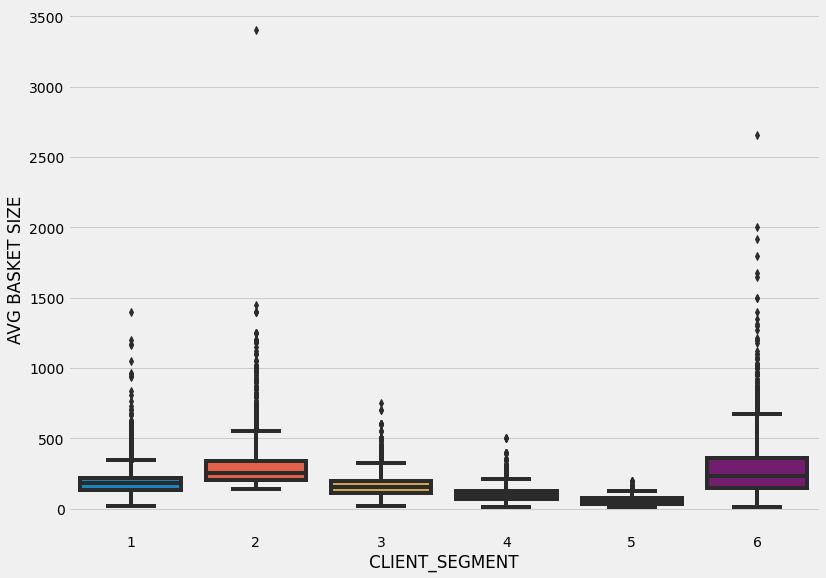

In [ ]:
_ = sns.boxplot(data=df_clientes,y='AVG BASKET SIZE', x='CLIENT_SEGMENT')

observamos algunos valores atipicos por encima de 2500 en los segmentos de clientes 2 y 6. Podemos ver que se trata de 2 pedidos que recibieron promocion. 



In [ ]:
df_clientes[df_clientes['AVG BASKET SIZE'] > 2500]

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
24465,19917710,2,1416.750,3400.200,1
28082,20939776,6,2433.330,2654.550,1


Por lo que podemos ver en ambos casos se tratan de valores probables ya que tanto la media de consumo como la de tamaño de la cesta son proporcionales. por lo que son datos factibles. 

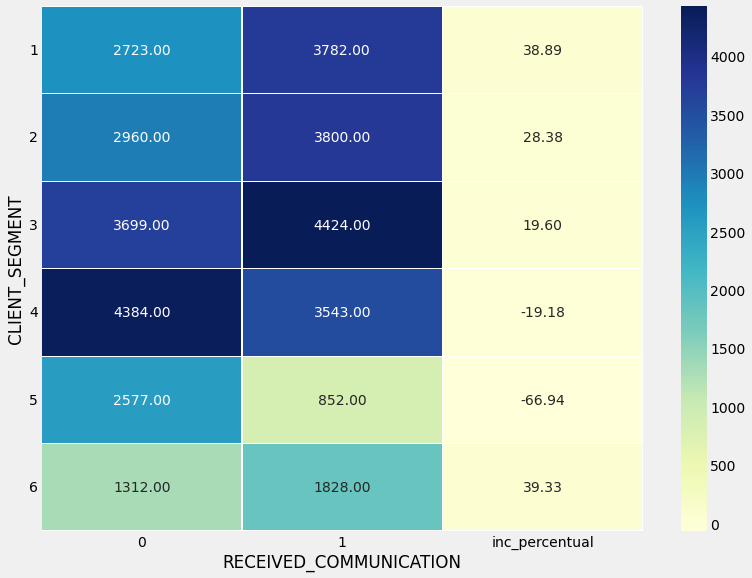

In [ ]:
table=df_clientes.pivot_table(values='CLIENT ID',index='CLIENT_SEGMENT',columns='RECEIVED_COMMUNICATION',aggfunc='count')
table['inc_percentual']=(table[1]-table[0])/table[0]*100
# table.sort_index(level=0,axis=0, ascending=False, inplace=True)
_=sns.heatmap(table,annot=True,linewidths=0.4,cmap="YlGnBu",fmt='.2f')
_=plt.yticks(rotation=0)

los clientes del segmento 4 y 5 reciben menos promociones que el resto de clientes

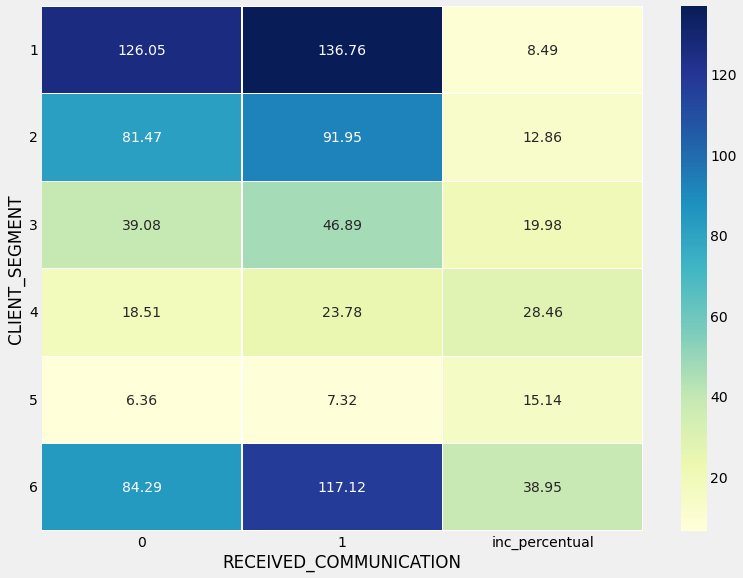

In [ ]:
table=df_clientes.pivot_table(values='AVG CONSO',index='CLIENT_SEGMENT',columns='RECEIVED_COMMUNICATION',aggfunc='mean')
table['inc_percentual']=(table[1]-table[0])/table[0]*100
# table.sort_index(level=0,axis=0, ascending=False, inplace=True)
_=sns.heatmap(table,annot=True,linewidths=0.4,cmap="YlGnBu",fmt='.2f')
_=plt.yticks(rotation=0)

A pesar de recibir menos promociones (los clientes del segmento 4 y 5), el consumo es mayor. 

Todos los segmentos de clientes consumen mas cuando tienen promociones.

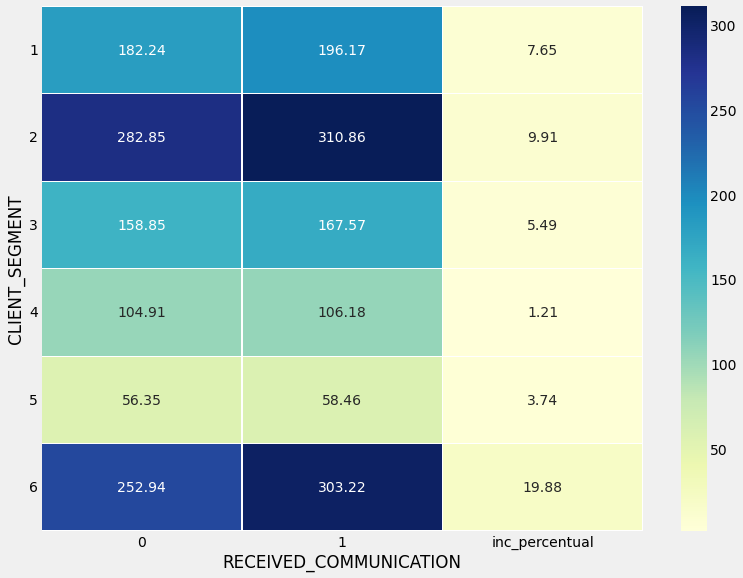

In [ ]:
table=df_clientes.pivot_table(values='AVG BASKET SIZE',index='CLIENT_SEGMENT',columns='RECEIVED_COMMUNICATION',aggfunc='mean')
table['inc_percentual']=(table[1]-table[0])/table[0]*100
# table.sort_index(level=0,axis=0, ascending=False, inplace=True)
_=sns.heatmap(table,annot=True,linewidths=0.4,cmap="YlGnBu",fmt='.2f')
_=plt.yticks(rotation=0)

por lo que se puede ver la media de consumo y de cesta es mayor cuando recibieron promocion de sus productos que cuando no recibieron.
Lo que indica que los clientes consumen mas y llenan mas la cesta cuando reciben alguna promocion de sus productos.
Por otro lado los grupos 4 y 5 podrian aumentar el consumo y el tamaño de la cesta si recibieran mas promociones. 

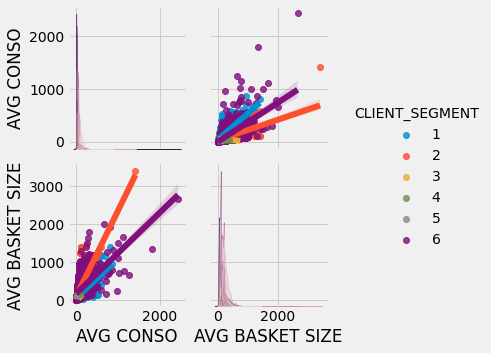

In [ ]:
sns.pairplot(df_clientes[['AVG CONSO','AVG BASKET SIZE','CLIENT_SEGMENT']],hue='CLIENT_SEGMENT',kind='reg')
plt.show()

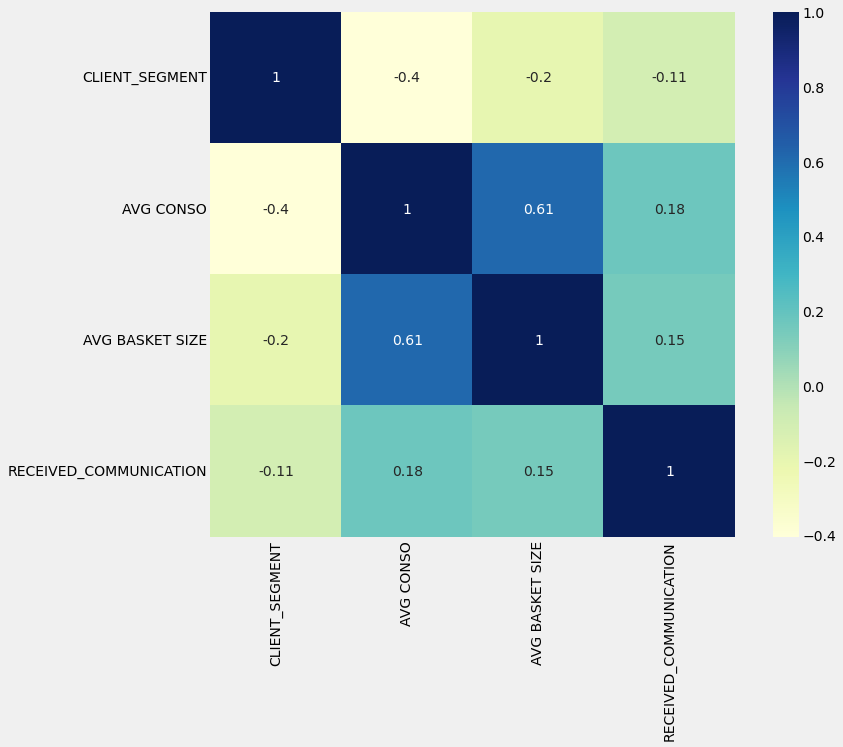

In [12]:
_=sns.heatmap(df_clientes.drop(columns='CLIENT ID').corr(), annot = True, cmap="YlGnBu", square=True)

como es de esperar el consumo y el tamaño de la cesta estan correlacionados. 

## División de los datos en conjuntos separados de entrenamiento y test

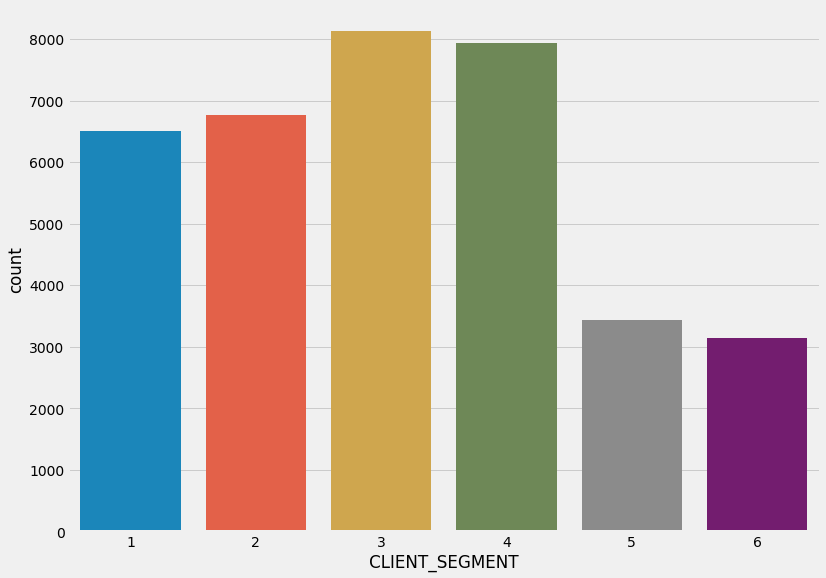

In [ ]:
# _=df_clientes.CLIENT_SEGMENT.value_counts().plot(kind='bar')
sns.countplot(data=df_clientes, x='CLIENT_SEGMENT')

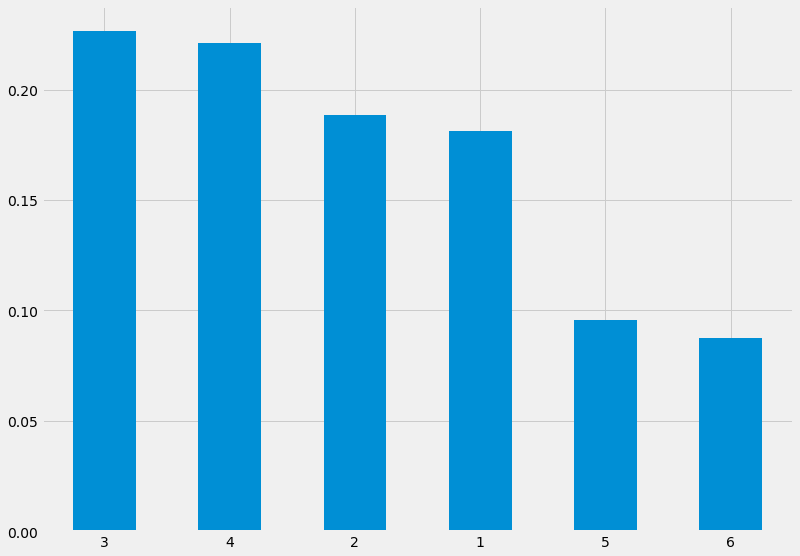

In [13]:
df_clientes['CLIENT_SEGMENT'].value_counts(normalize=True).plot(kind='bar',rot=0)

Vemos que la distribucion de los datos estan un poco desbalanceados. La proporcion de las clases 3 y 4 es mayor, siendo las clases mas perjudicadas la 5 y 6.

In [14]:
# eliminamos columnas que no aportan valor
df_clientes.drop(columns='CLIENT ID',inplace=True)

In [784]:
X=df_clientes.drop(columns=['CLIENT_SEGMENT'])
y=df_clientes['CLIENT_SEGMENT']

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        stratify=y,
                                        # test_size=0.70,
                                        random_state = 123,
                                    )

### Random Forest

Entrenamos el modelo con los valores por defecto de los hiperparametros

Matriz de confusión
-------------------


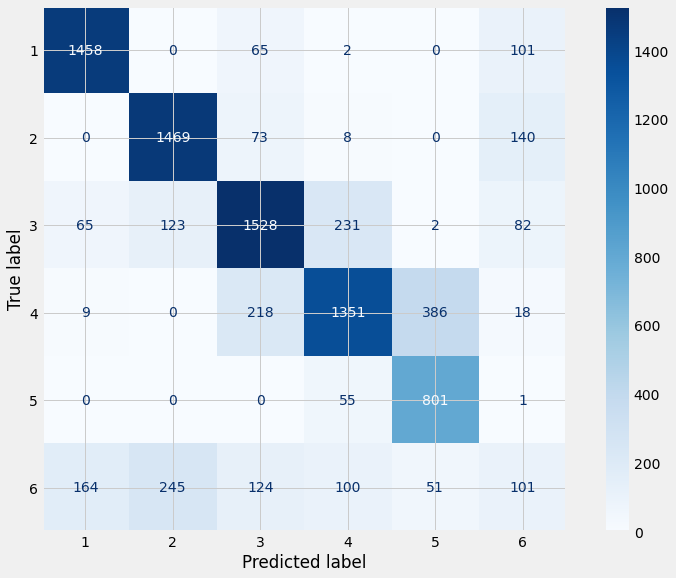


El accuracy de test es: 68.67407667391309 %


In [743]:
forest = RandomForestClassifier(class_weight='balanced',random_state=123)
# balanced", "balanced_subsample"
modelF = forest.fit(X_train, y_train)
predicciones = modelF.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=modelF.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

In [744]:
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           1       0.86      0.90      0.88      1626
           2       0.80      0.87      0.83      1690
           3       0.76      0.75      0.76      2031
           4       0.77      0.68      0.72      1982
           5       0.65      0.93      0.76       857
           6       0.23      0.13      0.16       785

    accuracy                           0.75      8971
   macro avg       0.68      0.71      0.69      8971
weighted avg       0.73      0.75      0.73      8971



buscamos los mejores valores de los hiperparametros

In [726]:
n_estimators = [20, 50, 100, 300, 500, 800]
max_depth = [2, 5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 10]

In [745]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(class_weight='balanced'),
                                X = X_train, y = y_train,
                                param_name = 'n_estimators',
                                param_range = n_estimators, cv = 3)

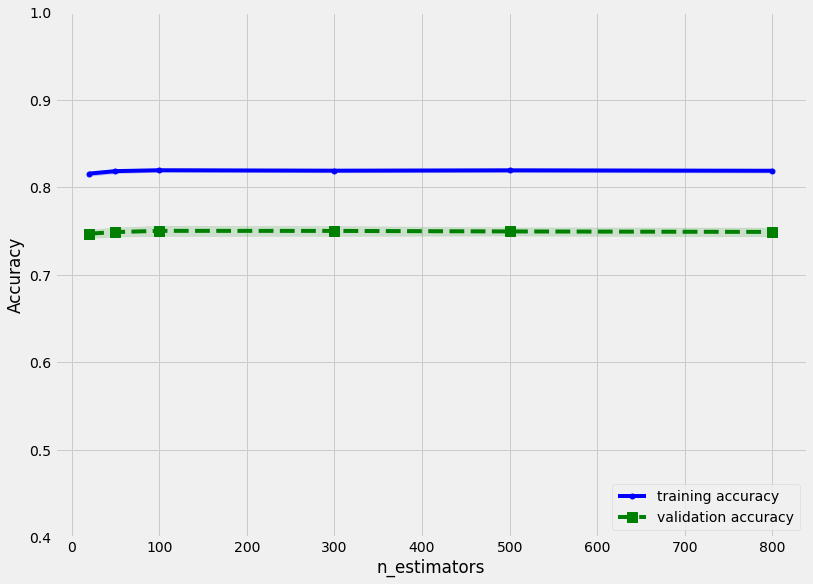

In [746]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(n_estimators, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(n_estimators, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(n_estimators, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(n_estimators,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1.0])
plt.show()

In [747]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(class_weight='balanced'),
                                X = X_train, y = y_train,
                                param_name = 'max_depth',
                                param_range = max_depth, cv = 3)

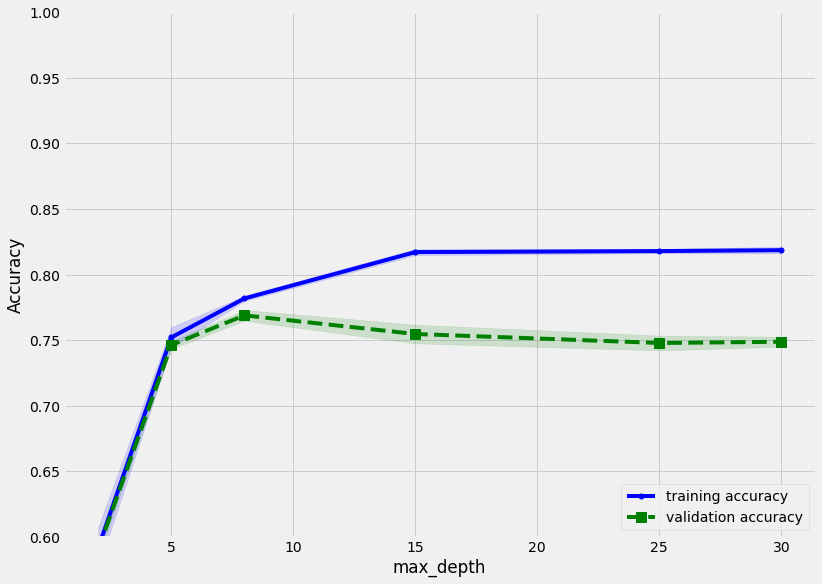

In [748]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(max_depth, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(max_depth, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(max_depth, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(max_depth,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1.0])
plt.show()

In [749]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(class_weight='balanced'),
                                X = X_train, y = y_train,
                                param_name = 'min_samples_split',
                                param_range = min_samples_split, cv = 3)

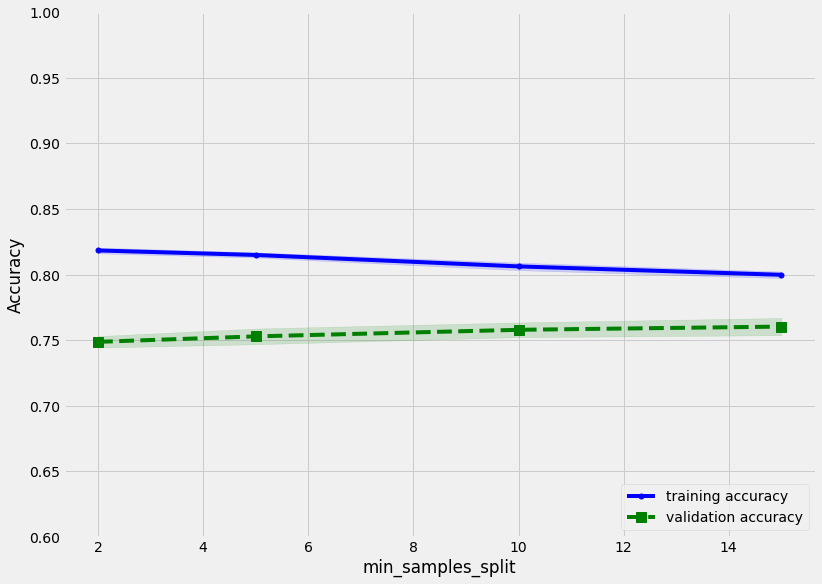

In [750]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(min_samples_split, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(min_samples_split, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(min_samples_split, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(min_samples_split,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1.0])
plt.show()

In [751]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(class_weight='balanced'),
                                X = X_train, y = y_train,
                                param_name = 'min_samples_leaf',
                                param_range = min_samples_leaf, cv = 3)

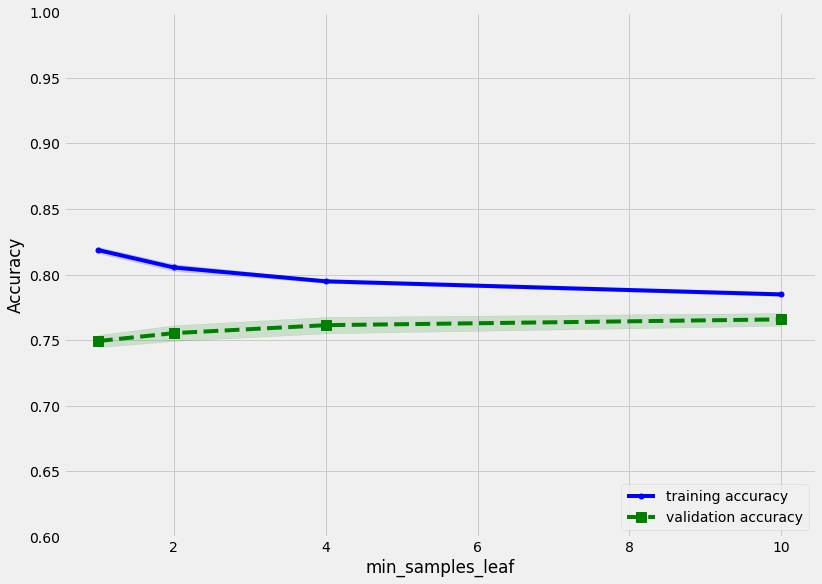

In [752]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(min_samples_leaf, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(min_samples_leaf, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(min_samples_leaf, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(min_samples_leaf,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1.0])
plt.show()

Matriz de confusión
-------------------


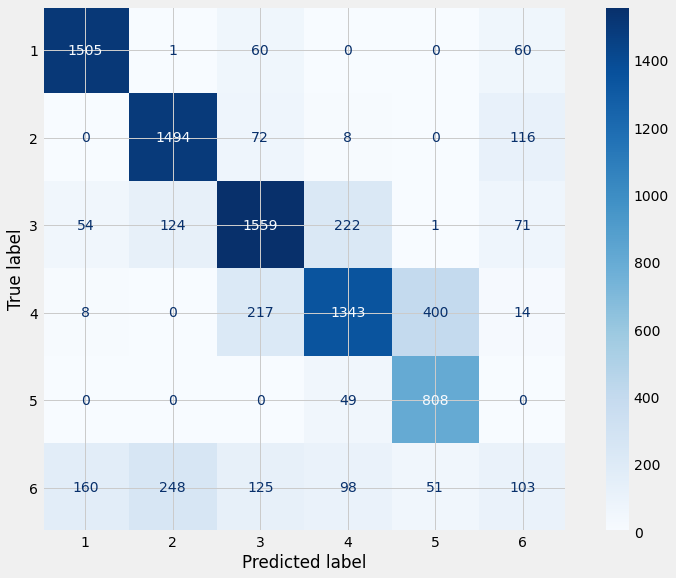


El accuracy de test es: 69.55243567825194 %


In [787]:
# forest = RandomForestClassifier(class_weight='balanced',random_state=123)
forestVC = RandomForestClassifier(random_state = 123,
                                  n_estimators = 100,
                                  max_depth = 15, 
                                  min_samples_split = 2,  
                                  min_samples_leaf = 4,
                                  class_weight='balanced') 
# balanced", "balanced_subsample"
modelFVC = forestVC.fit(X_train, y_train)
predicciones = modelFVC.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=modelFVC.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

In [788]:
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           1       0.87      0.93      0.90      1626
           2       0.80      0.88      0.84      1690
           3       0.77      0.77      0.77      2031
           4       0.78      0.68      0.73      1982
           5       0.64      0.94      0.76       857
           6       0.28      0.13      0.18       785

    accuracy                           0.76      8971
   macro avg       0.69      0.72      0.70      8971
weighted avg       0.74      0.76      0.74      8971



No handles with labels found to put in legend.


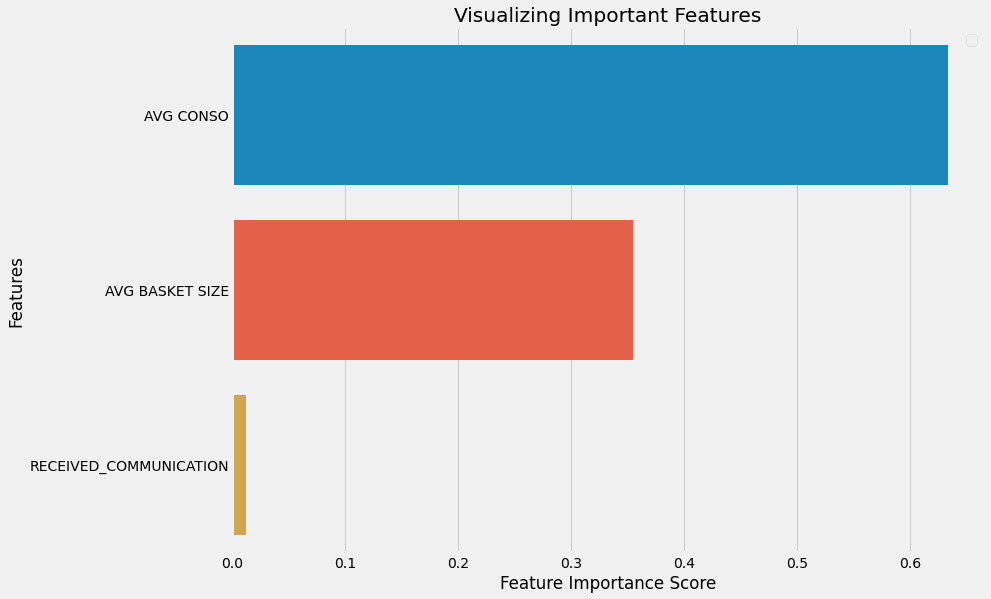

In [789]:
feature_imp = pd.Series(forestVC.feature_importances_,index=df_clientes.drop(columns=['CLIENT_SEGMENT']).columns)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Generating the Model on Selected Features

In [776]:
X=df_clientes.drop(columns=['RECEIVED_COMMUNICATION','CLIENT_SEGMENT']) # Removed feature "sepal length"
y=df_clientes['CLIENT_SEGMENT']                                      
# Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=5) # 70% training and 30% test
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        stratify=y,
                                        random_state = 123
                                    )

Matriz de confusión
-------------------


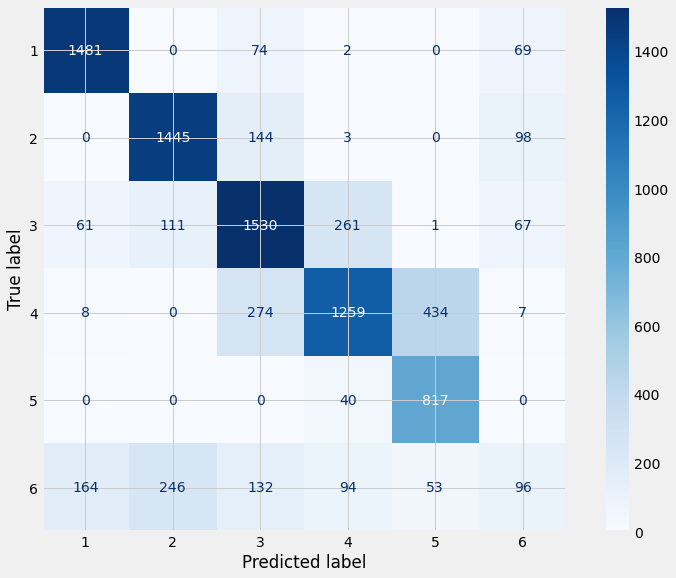


El accuracy de test es: 67.73480047059276 %


In [777]:
# forest = RandomForestClassifier(class_weight='balanced',random_state=123)
forestVCs = RandomForestClassifier(random_state = 123,
                                  n_estimators = 100,
                                  max_depth = 15, 
                                  min_samples_split = 2,  
                                  min_samples_leaf = 4,
                                  class_weight='balanced') 
# balanced", "balanced_subsample"
modelF = forestVCs.fit(X_train, y_train)
predicciones = modelF.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=modelF.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

In [778]:
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           1       0.86      0.91      0.89      1626
           2       0.80      0.86      0.83      1690
           3       0.71      0.75      0.73      2031
           4       0.76      0.64      0.69      1982
           5       0.63      0.95      0.76       857
           6       0.28      0.12      0.17       785

    accuracy                           0.74      8971
   macro avg       0.67      0.71      0.68      8971
weighted avg       0.72      0.74      0.72      8971



Puede ver que después de eliminar los rasgos menos importantes (si recibio o no promocion), la precisión no aumentó. Una menor cantidad de características no mejora el modelo


### KNN

In [199]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# Preprocesado y modelado KNN
from sklearn.neighbors import KNeighborsClassifier

In [200]:
# escalado de variables
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#instanciar el clasificador 
knn = KNeighborsClassifier(n_neighbors=7,weights='distance')

Matriz de confusión
-------------------


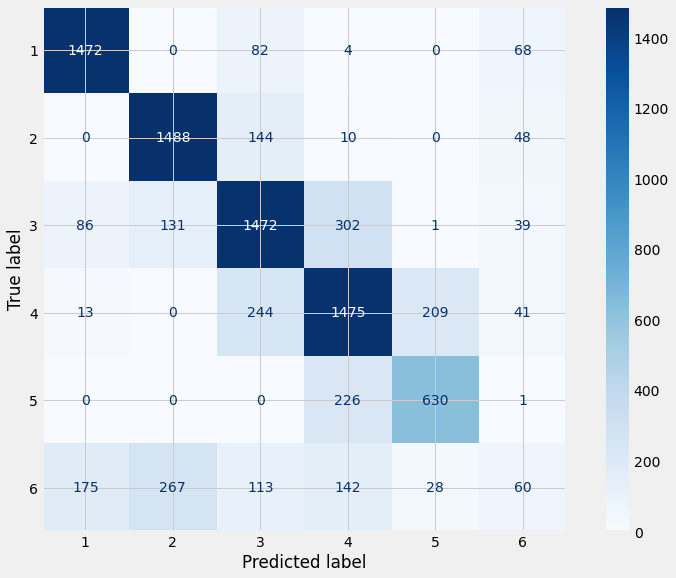

In [201]:
# ajustar el clasificador al conjunto de entrenamiento
knn.fit(X_train,y_train.values.ravel())

# prediccion de los resultados con el conjunto de test
y_pred = knn.predict(X_test)

# elaborar matriz de confusion
mat_confusion=confusion_matrix(y_test,y_pred)
print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [202]:
print(classification_report(y_test,y_pred))
print(f"El accuracy de test es: {100 * f1_score(y_test, y_pred, average='macro')} %")

              precision    recall  f1-score   support

           1       0.84      0.91      0.87      1626
           2       0.79      0.88      0.83      1690
           3       0.72      0.72      0.72      2031
           4       0.68      0.74      0.71      1982
           5       0.73      0.74      0.73       857
           6       0.23      0.08      0.12       785

    accuracy                           0.74      8971
   macro avg       0.67      0.68      0.66      8971
weighted avg       0.70      0.74      0.72      8971

El accuracy de test es: 66.39637372386112 %


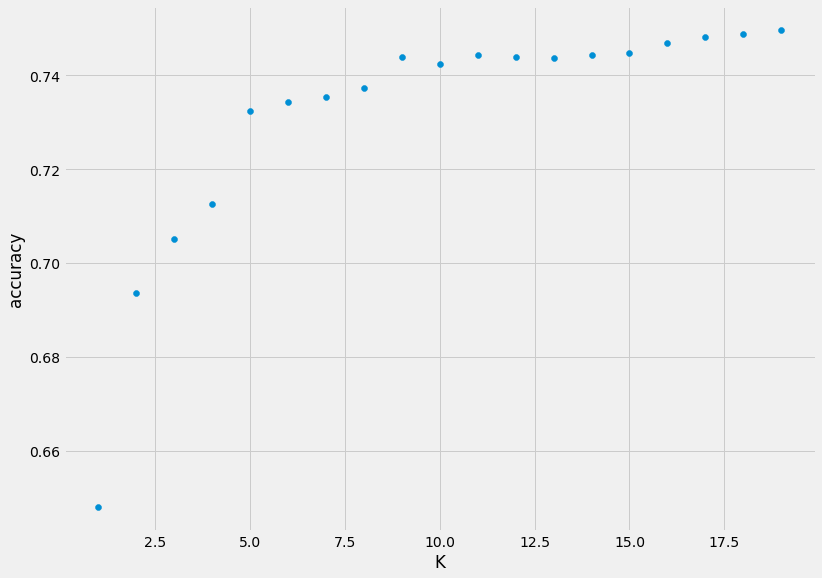

In [203]:
k_range = range(1,20)

scores=[]
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k,weights='distance')
  knn.fit(X_train,y_train.values.ravel())
  knn.predict(X_test)
  
  scores.append(knn.score(X_test,y_test))

plt.xlabel('K')
plt.ylabel('accuracy')
plt.scatter(k_range,scores)

In [204]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [205]:
print(Counter(y_train))

oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X_train,y_train)

# strategy = {1:6025, 2:6000, 3:6000, 4:6025, 5:6025, 6:6025}
# oversample = SMOTE(sampling_strategy=strategy)

steps = [('0', oversample)]
pipeline = Pipeline(steps)
X_resample, y_resample = pipeline.fit_resample(X_train,y_train.values.ravel())

print(Counter(y_resample))

Counter({3: 6092, 4: 5945, 2: 5070, 1: 4879, 5: 2572, 6: 2355})
Counter({1: 6092, 3: 6092, 2: 6092, 4: 6092, 5: 6092, 6: 6092})


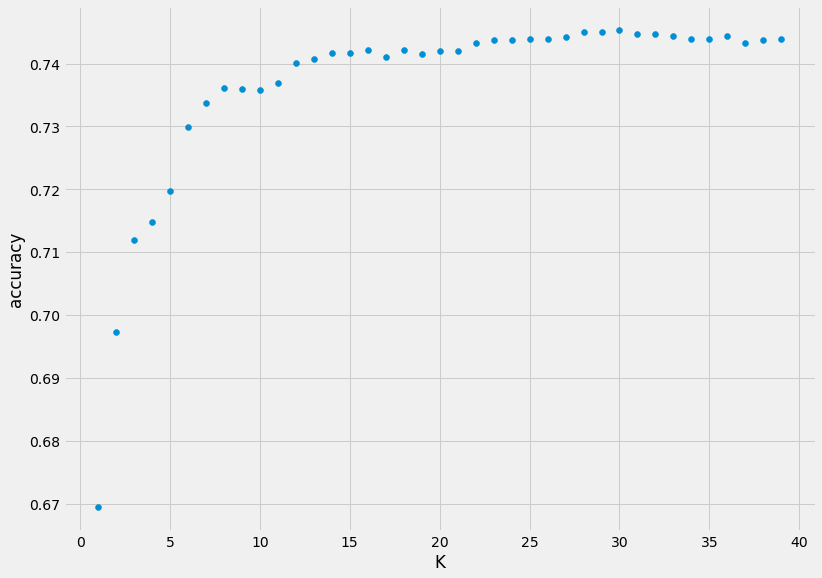

In [206]:
k_range = range(1,40)

scores=[]
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k,weights='distance')
  knn.fit(X_resample,y_resample)
  knn.predict(X_test)
  
  scores.append(knn.score(X_test,y_test))

plt.xlabel('K')
plt.ylabel('accuracy')
plt.scatter(k_range,scores)

In [207]:
#instanciar el clasificador 
knn = KNeighborsClassifier(n_neighbors=30,weights='distance')

Matriz de confusión
-------------------


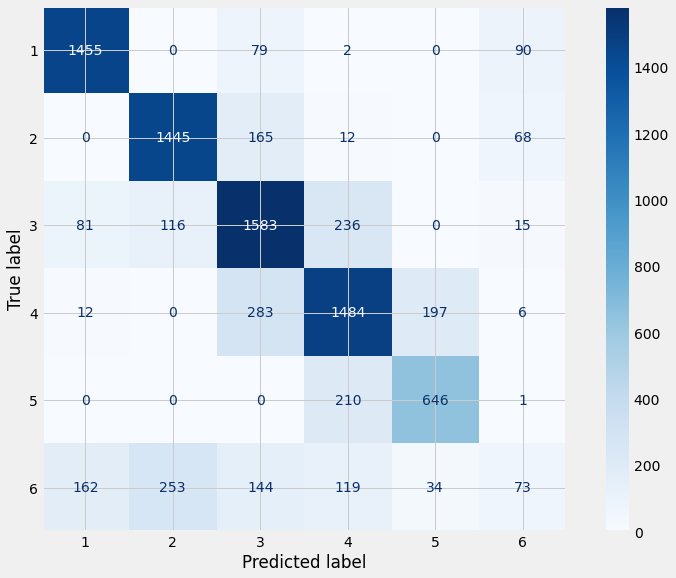

In [208]:
# ajustar el clasificador al conjunto de entrenamiento
knn.fit(X_resample,y_resample)

# prediccion de los resultados con el conjunto de test
y_pred = knn.predict(X_test)

# elaborar matriz de confusion
mat_confusion=confusion_matrix(y_test,y_pred)
print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [209]:
print(classification_report(y_test,y_pred))
print(f"El accuracy de test es: {100 * f1_score(y_test, y_pred, average='macro')} %")

              precision    recall  f1-score   support

           1       0.85      0.89      0.87      1626
           2       0.80      0.86      0.82      1690
           3       0.70      0.78      0.74      2031
           4       0.72      0.75      0.73      1982
           5       0.74      0.75      0.75       857
           6       0.29      0.09      0.14       785

    accuracy                           0.75      8971
   macro avg       0.68      0.69      0.68      8971
weighted avg       0.72      0.75      0.73      8971

El accuracy de test es: 67.59048056144783 %


### ANN

In [637]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/tensorflow_addons-0.15.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [795]:
from sklearn.model_selection import train_test_split

import keras
from keras import metrics 
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
from tensorflow.keras.utils import to_categorical
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
import tensorflow_addons as tfa

from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [796]:
#Changing pandas dataframe to numpy array
features = df_clientes.drop(columns='CLIENT_SEGMENT').values
labels = df_clientes.loc[:,'CLIENT_SEGMENT'].values

In [797]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

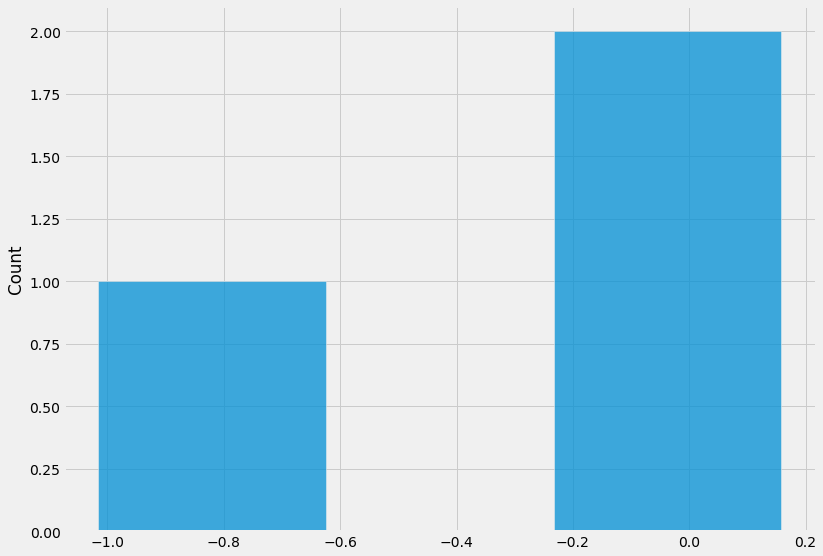

In [798]:
_=sns.histplot(features[0])

In [799]:
train_x, test_x, train_y, test_y = train_test_split(features, labels,stratify=labels, random_state=123)

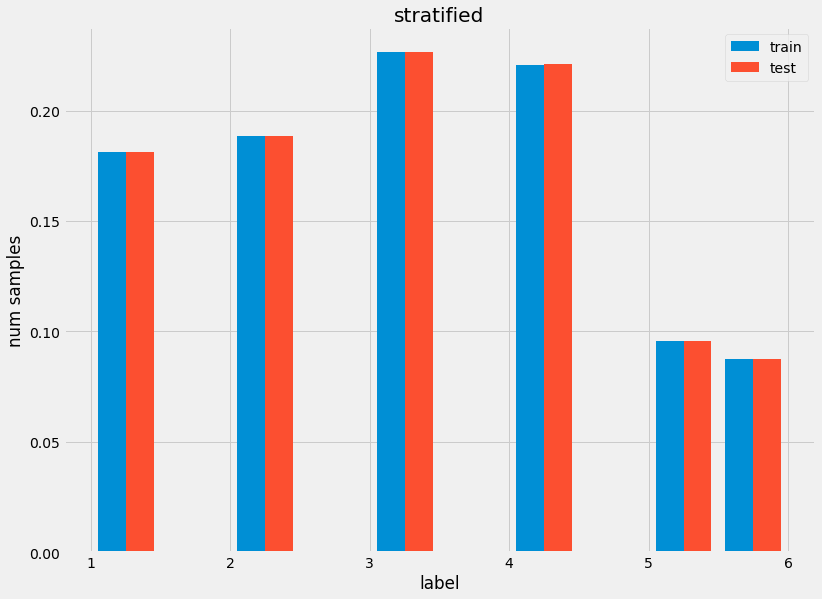

In [800]:
weights = [np.ones_like(train_y) / train_y.size, # np.ones_like generates an array of ones 
           np.ones_like(test_y) / test_y.size]  
plt.hist([train_y,test_y],label=["train","test"],stacked=False, weights=weights)
plt.xlabel("label")
plt.ylabel("num samples")
plt.title("stratified")
_=plt.legend()

In [801]:
print('Dimension conjunto de train :{}, tipo de dato: {}'.format(train_x.shape,train_x.dtype))

Dimension conjunto de train :(26913, 3), tipo de dato: float64


In [802]:
print('Dimension conjunto de test :{}, tipo de dato: {}'.format(train_y.shape,train_y.dtype))

Dimension conjunto de test :(26913,), tipo de dato: int64


In [803]:
print('Dimension conjunto de test :{}, tipo de dato: {}'.format(test_x.shape,test_x.dtype))

Dimension conjunto de test :(8971, 3), tipo de dato: float64


In [804]:
print('Dimension conjunto de test :{}, tipo de dato: {}'.format(test_y.shape,test_y.dtype))

Dimension conjunto de test :(8971,), tipo de dato: int64


In [805]:
response_train_y = pd.Categorical(train_y.reshape(-1))
train_y_dummies = to_categorical(response_train_y.codes)
train_y_dummies

response_test_y = pd.Categorical(test_y.reshape(-1))
test_y_dummies = to_categorical(response_test_y.codes)
test_y_dummies


array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

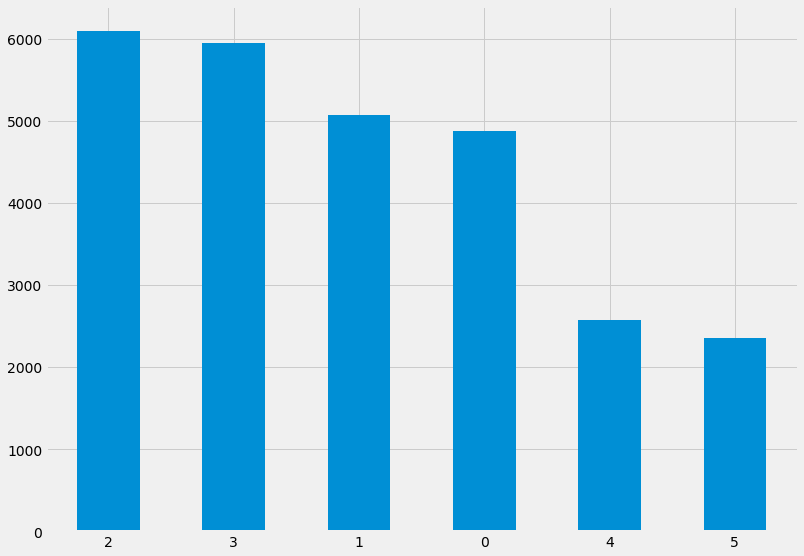

In [806]:
_=pd.value_counts(train_y_dummies.argmax(axis=1)).plot(kind='bar',rot=0)

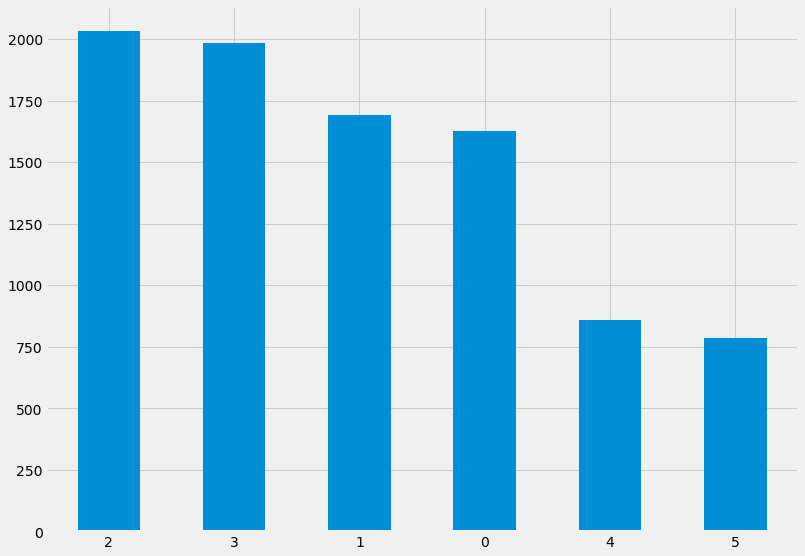

In [807]:
_=pd.value_counts(test_y_dummies.argmax(axis=1)).plot(kind='bar',rot=0)

In [808]:
def create_model():
  model = Sequential()
  model.add(Dense(10, activation='relu',input_dim=3))
  model.add(Dense(8, activation='relu'))
  # model.add(Dense(10,activation='relu'))
  # model.add(Dense(8,activation='relu'))
  model.add(Dense(6,activation='softmax'))
  return model
  
model = create_model()
model.summary()

Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_793 (Dense)           (None, 10)                40        
                                                                 
 dense_794 (Dense)           (None, 8)                 88        
                                                                 
 dense_795 (Dense)           (None, 6)                 54        
                                                                 
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


In [809]:
batch_size = [32,64,128,256,512]
results = {}
tiempo = {}
for batch in batch_size:
  model = create_model()
  model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01),metrics=[tfa.metrics.F1Score(num_classes=6, average='macro',threshold=0.5)])
  history = model.fit(train_x,train_y_dummies,epochs=20,batch_size=batch,validation_data=(test_x,test_y_dummies),verbose=0)
  results[batch] = history

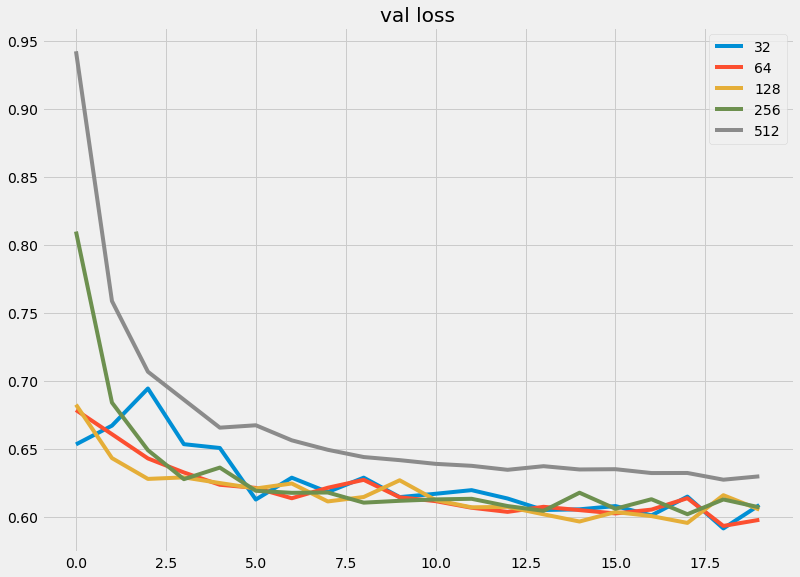

In [810]:
val_loss_batch = { k:v.history['val_loss'] for k,v in results.items()}

val_loss = pd.DataFrame(val_loss_batch)
val_loss.plot(title='val loss')

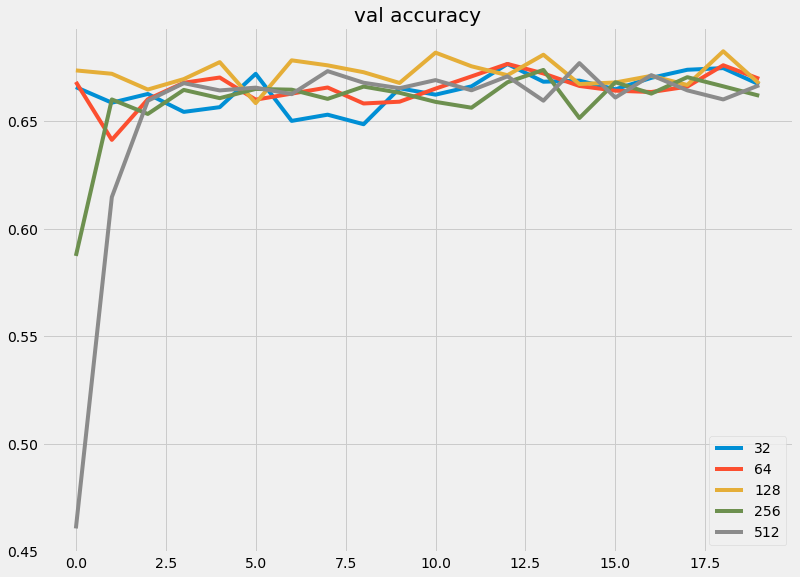

In [812]:
val_accuracy_batch = { k:v.history['val_f1_score'] for k,v in results.items()}

val_accuracy = pd.DataFrame(val_accuracy_batch)
val_accuracy.plot(title='val accuracy')

In [813]:
optimizers = [Adam, SGD, Adadelta, Adagrad]
learningsr = [0.001, 0.01, 0.05, 0.1] 

def grid_search_params(optimizers,learningsr):
  results = {"Learning rate": [], "Accuracy": [], "Loss": [], "Optimizer": [], "History": [], "Model": []}
  for op in optimizers:
    for lr in learningsr:
      model=create_model()
      model.compile(loss='categorical_crossentropy',optimizer=op(learning_rate=lr),metrics=[tfa.metrics.F1Score(num_classes=6, average='macro',threshold=0.5)])
      history = model.fit(train_x,train_y_dummies,epochs=20,batch_size=256,validation_data=(test_x,test_y_dummies),verbose=0)
      results['Learning rate'].append(lr)
      results['Accuracy'].append(model.evaluate(test_x, test_y_dummies, verbose=0)[1])
      results['Loss'].append(model.evaluate(test_x, test_y_dummies, verbose=0)[0])
      results['Optimizer'].append(str(op))
      results['History'].append(history)
      results['Model'] = model
  return pd.DataFrame(results)

resultados=grid_search_params(optimizers,learningsr)
resultados 

,Learning rate,Accuracy,Loss,Optimizer,History,Model
0,0.001,0.671611,0.668403,<class 'keras.optimizer_v2.adam.Adam'>,<keras.callbacks.History object at 0x7f36ae407...,<keras.engine.sequential.Sequential object at ...
1,0.010,0.663683,0.608661,<class 'keras.optimizer_v2.adam.Adam'>,<keras.callbacks.History object at 0x7f36b4489...,<keras.engine.sequential.Sequential object at ...
2,0.050,0.659769,0.620465,<class 'keras.optimizer_v2.adam.Adam'>,<keras.callbacks.History object at 0x7f36ae47b...,<keras.engine.sequential.Sequential object at ...
3,0.100,0.665002,0.605622,<class 'keras.optimizer_v2.adam.Adam'>,<keras.callbacks.History object at 0x7f369d3e2...,<keras.engine.sequential.Sequential object at ...
4,0.001,0.006183,1.670458,<class 'keras.optimizer_v2.gradient_descent.SGD'>,<keras.callbacks.History object at 0x7f36b4222...,<keras.engine.sequential.Sequential object at ...
5,0.010,0.457982,0.963970,<class 'keras.optimizer_v2.gradient_descent.SGD'>,<keras.callbacks.History object at 0x7f36b3f99...,<keras.engine.sequential.Sequential object at ...
6,0.050,0.655034,0.666736,<class 'keras.optimizer_v2.gradient_descent.SGD'>,<keras.callbacks.History object at 0x7f369d4fe...,<keras.engine.sequential.Sequential object at ...
7,0.100,0.657944,0.851027,<class 'keras.optimizer_v2.gradient_descent.SGD'>,<keras.callbacks.History object at 0x7f36b40e7...,<keras.engine.sequential.Sequential object at ...
8,0.001,0.000000,1.910606,<class 'keras.optimizer_v2.adadelta.Adadelta'>,<keras.callbacks.History object at 0x7f36ae751...,<keras.engine.sequential.Sequential object at ...
9,0.010,0.005455,1.764283,<class 'keras.optimizer_v2.adadelta.Adadelta'>,<keras.callbacks.History object at 0x7f36ae65b...,<keras.engine.sequential.Sequential object at ...


In [814]:
early_stopping=EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,verbose=1)

model = create_model()
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=[tfa.metrics.F1Score(num_classes=6, average='macro',threshold=0.5)])
history = model.fit(train_x,train_y_dummies,epochs=20,batch_size=256,validation_data=(test_x,test_y_dummies),callbacks=[early_stopping])

Epoch 1/20
106/106 [==============================] - 2s 14ms/step - loss: 1.6802 - f1_score: 6.5733e-05 - val_loss: 1.5663 - val_f1_score: 0.0000e+00
Epoch 2/20
106/106 [==============================] - 1s 7ms/step - loss: 1.4716 - f1_score: 0.0014 - val_loss: 1.3775 - val_f1_score: 0.0082
Epoch 3/20
106/106 [==============================] - 1s 6ms/step - loss: 1.2752 - f1_score: 0.0516 - val_loss: 1.1841 - val_f1_score: 0.1056
Epoch 4/20
106/106 [==============================] - 1s 5ms/step - loss: 1.0967 - f1_score: 0.2056 - val_loss: 1.0354 - val_f1_score: 0.2507
Epoch 5/20
106/106 [==============================] - 0s 4ms/step - loss: 0.9744 - f1_score: 0.3523 - val_loss: 0.9328 - val_f1_score: 0.4205
Epoch 6/20
106/106 [==============================] - 0s 4ms/step - loss: 0.8918 - f1_score: 0.4834 - val_loss: 0.8682 - val_f1_score: 0.5236
Epoch 7/20
106/106 [==============================] - 1s 6ms/step - loss: 0.8369 - f1_score: 0.5516 - val_loss: 0.8206 - val_f1_score: 0.56

In [815]:
mse_test = model.evaluate(test_x,test_y_dummies)

281/281 [==============================] - 0s 1ms/step - loss: 0.6697 - f1_score: 0.6651


(0.0, 1.0)

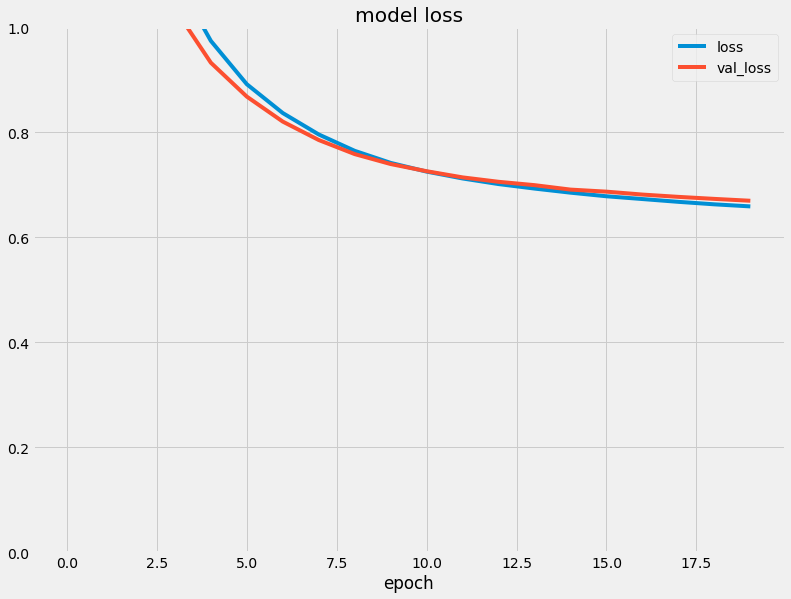

In [816]:
hist= pd.DataFrame(history.history)
hist[['loss','val_loss']].plot(xlabel='epoch',title='model loss')
plt.gca().set_ylim(0,1)

(0.0, 1.0)

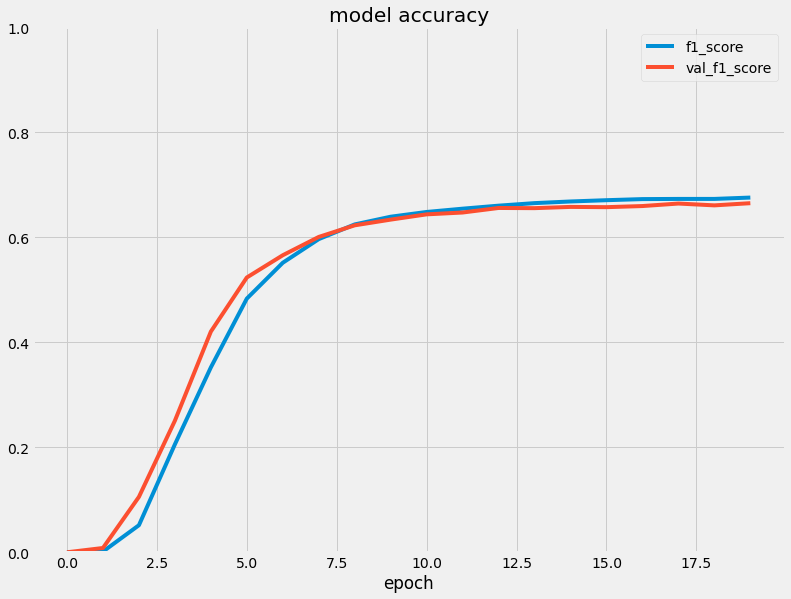

In [817]:
hist[['f1_score','val_f1_score']].plot(xlabel='epoch',title='model accuracy')
plt.gca().set_ylim(0,1)

In [818]:
y_pred = model.predict(test_x)
y_pred

array([[2.0659873e-07, 7.5383161e-07, 1.4131408e-02, 8.4462041e-01,
        8.5717499e-02, 5.5529654e-02],
       [9.5524293e-01, 7.0273760e-03, 3.4773971e-03, 2.8706685e-05,
        5.0446383e-12, 3.4223668e-02],
       [3.8221351e-09, 1.1196707e-07, 7.1289728e-04, 1.6569084e-01,
        8.2600427e-01, 7.5918534e-03],
       ...,
       [8.3090872e-02, 7.1515673e-01, 3.9551542e-03, 2.8588442e-05,
        4.2233769e-11, 1.9776866e-01],
       [2.9168786e-02, 8.3986640e-01, 1.4283045e-02, 2.3309961e-04,
        8.0310141e-09, 1.1644877e-01],
       [5.9621141e-04, 2.5566390e-02, 8.3260965e-01, 9.0099767e-02,
        3.1727493e-05, 5.1096264e-02]], dtype=float32)

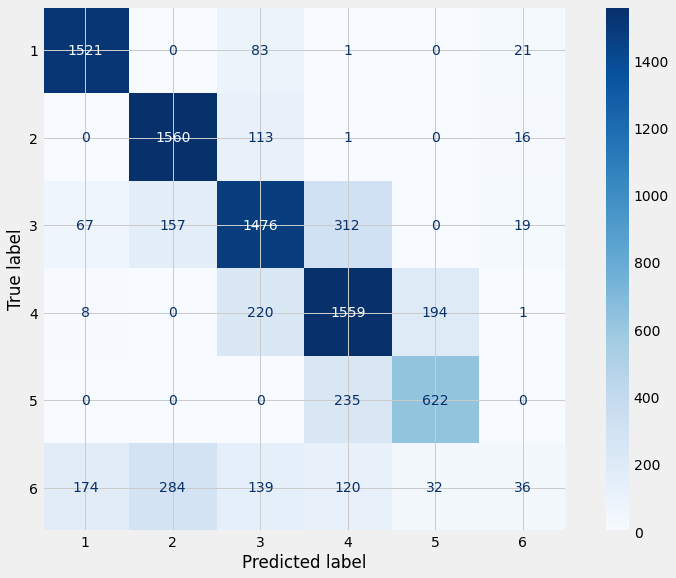

In [819]:
cm=confusion_matrix(test_y_dummies.argmax(axis=1),y_pred.argmax(axis=1))
ls=response_test_y.categories

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ls)

# sns.heatmap(disp.confusion_matrix,annot=True,cmap='Blues',square=True,fmt='d')
disp.plot(include_values=True, cmap='Blues',values_format='d')
plt.show()

In [820]:
# print('Accuracy: {}'.format(accuracy_score(y_pred.argmax(axis=1),test_y.argmax(axis=1))))
print(f"El accuracy de test es: {100 * f1_score(y_pred.argmax(axis=1),test_y_dummies.argmax(axis=1), average='macro')} %")
target_names=list(map(str,response_test_y.categories.to_list()))
print(classification_report(test_y_dummies.argmax(axis=1),y_pred.argmax(axis=1),target_names=target_names))

El accuracy de test es: 67.00059322898088 %
              precision    recall  f1-score   support

           1       0.86      0.94      0.90      1626
           2       0.78      0.92      0.85      1690
           3       0.73      0.73      0.73      2031
           4       0.70      0.79      0.74      1982
           5       0.73      0.73      0.73       857
           6       0.39      0.05      0.08       785

    accuracy                           0.76      8971
   macro avg       0.70      0.69      0.67      8971
weighted avg       0.73      0.76      0.73      8971



no se consigue mejorar la precision del modelo.

## Predicción conjunto de test

recuperamos el mejor modelo (Random Forest con ajuste de hiperparametros):

In [780]:
pd.read_csv('Example__results.csv').head()

,CLIENT ID,CLIENT_SEGMENT
0,48352078,1
1,18072186,2
2,48352246,1
3,18070621,5
4,48352262,3


In [791]:
predicciones = modelFVC.predict(df_test.drop(columns=['CLIENT ID']))
df_test['CLIENT_SEGMENT'] = predicciones
# guardamos los datos de la prediccion del mejor modelo en un csv
df_test[['CLIENT ID','CLIENT_SEGMENT']].to_csv('predicciones.csv',index=None)

In [794]:

# df_res = pd.DataFrame(predicciones,columns=['final_status'])
